# 4.2 Definición, entrenamiento, evaluación e inferencia.

In [ ]:
import pandas as pd
import numpy as np

# Análisis de los datos

Primero se cargan los datos del archivo csv que contiene toda la información preprocesada en la sección anterior.

In [ ]:
test = pd.read_csv('test_data.csv')
train = pd.read_csv('train_data.csv')
validation = pd.read_csv('validation_data.csv')

In [ ]:
train.head()

,Unnamed: 0,building_id,square_feet(t-6),air_temperature(t-6),dew_temperature(t-6),sea_level_pressure(t-6),wind_direction(t-6),wind_speed(t-6),pressure_meter(t-6),month(t-6),day(t-6),weekday(t-6),hour(t-6),square_feet(t-5),air_temperature(t-5),dew_temperature(t-5),sea_level_pressure(t-5),wind_direction(t-5),wind_speed(t-5),pressure_meter(t-5),month(t-5),day(t-5),weekday(t-5),hour(t-5),square_feet(t-4),air_temperature(t-4),dew_temperature(t-4),sea_level_pressure(t-4),wind_direction(t-4),wind_speed(t-4),pressure_meter(t-4),month(t-4),day(t-4),weekday(t-4),hour(t-4),square_feet(t-3),air_temperature(t-3),dew_temperature(t-3),sea_level_pressure(t-3),wind_direction(t-3),wind_speed(t-3),pressure_meter(t-3),month(t-3),day(t-3),weekday(t-3),hour(t-3),square_feet(t-2),air_temperature(t-2),dew_temperature(t-2),sea_level_pressure(t-2),wind_direction(t-2),wind_speed(t-2),pressure_meter(t-2),month(t-2),day(t-2),weekday(t-2),hour(t-2),square_feet(t-1),air_temperature(t-1),dew_temperature(t-1),sea_level_pressure(t-1),wind_direction(t-1),wind_speed(t-1),pressure_meter(t-1),month(t-1),day(t-1),weekday(t-1),hour(t-1),electricity(t-6),electricity(t-5),electricity(t-4),electricity(t-3),electricity(t-2),electricity(t-1),electricity(t)
0,0,127,27071.0,3.8,2.4,1020.9,5.0,3.1,1.0,1.0,1.0,4.0,0.0,27071.0,3.7,2.4,1021.6,5.0,2.6,1.0,1.0,1.0,5.0,1.0,27071.0,2.6,1.9,1021.9,0.0,0.0,1.0,1.0,1.0,6.0,2.0,27071.0,2.0,1.2,1022.3,4.0,1.5,1.0,1.0,1.0,7.0,3.0,27071.0,2.3,1.8,1022.7,2.0,1.5,1.0,1.0,1.0,1.0,4.0,27071.0,2.4,2.0,1023.0,2.0,1.0,1.0,1.0,1.0,2.0,5.0,8.6786,17.3571,17.3571,17.3571,17.3571,17.3571,17.3571
1,1,127,27071.0,3.7,2.4,1021.6,5.0,2.6,1.0,1.0,1.0,5.0,1.0,27071.0,2.6,1.9,1021.9,0.0,0.0,1.0,1.0,1.0,6.0,2.0,27071.0,2.0,1.2,1022.3,4.0,1.5,1.0,1.0,1.0,7.0,3.0,27071.0,2.3,1.8,1022.7,2.0,1.5,1.0,1.0,1.0,1.0,4.0,27071.0,2.4,2.0,1023.0,2.0,1.0,1.0,1.0,1.0,2.0,5.0,27071.0,2.3,1.8,1023.0,2.0,1.5,1.0,1.0,1.0,3.0,6.0,17.3571,17.3571,17.3571,17.3571,17.3571,17.3571,17.3571
2,2,127,27071.0,2.6,1.9,1021.9,0.0,0.0,1.0,1.0,1.0,6.0,2.0,27071.0,2.0,1.2,1022.3,4.0,1.5,1.0,1.0,1.0,7.0,3.0,27071.0,2.3,1.8,1022.7,2.0,1.5,1.0,1.0,1.0,1.0,4.0,27071.0,2.4,2.0,1023.0,2.0,1.0,1.0,1.0,1.0,2.0,5.0,27071.0,2.3,1.8,1023.0,2.0,1.5,1.0,1.0,1.0,3.0,6.0,27071.0,2.6,1.9,1022.5,2.0,1.0,1.0,1.0,1.0,4.0,7.0,17.3571,17.3571,17.3571,17.3571,17.3571,17.3571,17.3571
3,3,127,27071.0,2.0,1.2,1022.3,4.0,1.5,1.0,1.0,1.0,7.0,3.0,27071.0,2.3,1.8,1022.7,2.0,1.5,1.0,1.0,1.0,1.0,4.0,27071.0,2.4,2.0,1023.0,2.0,1.0,1.0,1.0,1.0,2.0,5.0,27071.0,2.3,1.8,1023.0,2.0,1.5,1.0,1.0,1.0,3.0,6.0,27071.0,2.6,1.9,1022.5,2.0,1.0,1.0,1.0,1.0,4.0,7.0,27071.0,2.2,1.5,1022.3,1.0,1.0,1.0,1.0,1.0,5.0,8.0,17.3571,17.3571,17.3571,17.3571,17.3571,17.3571,17.3571
4,4,127,27071.0,2.3,1.8,1022.7,2.0,1.5,1.0,1.0,1.0,1.0,4.0,27071.0,2.4,2.0,1023.0,2.0,1.0,1.0,1.0,1.0,2.0,5.0,27071.0,2.3,1.8,1023.0,2.0,1.5,1.0,1.0,1.0,3.0,6.0,27071.0,2.6,1.9,1022.5,2.0,1.0,1.0,1.0,1.0,4.0,7.0,27071.0,2.2,1.5,1022.3,1.0,1.0,1.0,1.0,1.0,5.0,8.0,27071.0,2.2,1.2,1022.0,2.0,2.6,1.0,1.0,1.0,6.0,9.0,17.3571,17.3571,17.3571,17.3571,17.3571,17.3571,17.3571



Procedemos a eliminar las columnas innecesarias, es decir, las columnas "Unnamed: 0" y "building_id"

In [ ]:
train = train.drop(["Unnamed: 0"], axis=1)
train = train.drop(["building_id"], axis=1)
test = test.drop(["Unnamed: 0"], axis=1)
test = test.drop(["building_id"], axis=1)
validation = validation.drop(["Unnamed: 0"], axis=1)
validation = validation.drop(["building_id"], axis=1)

In [ ]:
train.shape

(765839, 73)

In [ ]:
test.shape

(52211, 73)

In [ ]:
validation.shape

(173082, 73)

Procedemos a normalizar los datos utilizando las funciones MinMaxScaler y StandardScaler de la librería "skylearn".

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


train_x = train.values[:, :-1]
train_y = train.values[:, -1:]

val_x = validation.values[:, :-1]
val_y = validation.values[:, -1:]

test_x= test.values[:, :-1]
test_y= test.values[:, -1:]

# load data
train_x_values1 = train_x
train_y_values1 = train_y
validation_x_values1 = val_x
validation_y_values1 = val_y
test_x_values1 = test_x
test_y_values1 = test_y

# check data is float
train_x_values = train_x_values1.astype('float32')
validation_x_values = validation_x_values1.astype('float32')
test_x_values = test_x_values1.astype('float32')
train_y_values = train_y_values1.astype('float32')
validation_y_values = validation_y_values1.astype('float32')
test_y_values = test_y_values1.astype('float32')
# normalizing

scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = StandardScaler()

train_x = scaler_x.fit_transform(train_x_values)
val_x = scaler_x.transform(validation_x_values)
test_x = scaler_x.transform(test_x_values)

train_y = scaler_y.fit_transform(train_y_values)
val_y = scaler_y.transform(validation_y_values)
test_y = scaler_y.transform(test_y_values)

Redimensionamos los vectores de entrada.

In [ ]:
n_hours = 6
n_features = 12
train_x = train_x.reshape((train_x.shape[0], (n_hours), n_features))
test_x = test_x.reshape((test_x.shape[0], (n_hours), n_features))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(765839, 6, 12) (765839, 1) (52211, 6, 12) (52211, 1)


Definición del modelo

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from matplotlib import pyplot

Definimos un segundo modelo implementando una red Bidirectional con LSTM con 100 neuronas en la capa oculta, una función de activación tipo 'relu', utilizando un optimizador Adam y una MSE como función de perdida.

Se utilizo un entorno de ejecución TPU entrenando el modelo con 50 épocas ya que el entrenamiento del modelo se prolongaba hasta 4 horas

Epoch 1/50
10637/10637 [==============================] - 241s 22ms/step - loss: 0.2044 - val_loss: 0.6080
Epoch 2/50
10637/10637 [==============================] - 237s 22ms/step - loss: 0.2122 - val_loss: 0.6688
Epoch 3/50
10637/10637 [==============================] - 249s 23ms/step - loss: 0.2278 - val_loss: 0.6152
Epoch 4/50
10637/10637 [==============================] - 238s 22ms/step - loss: 0.2070 - val_loss: 0.6166
Epoch 5/50
10637/10637 [==============================] - 238s 22ms/step - loss: 0.2201 - val_loss: 0.5936
Epoch 6/50
10637/10637 [==============================] - 239s 22ms/step - loss: 0.2244 - val_loss: 0.6084
Epoch 7/50
10637/10637 [==============================] - 238s 22ms/step - loss: 0.1766 - val_loss: 0.1856
Epoch 8/50
10637/10637 [==============================] - 237s 22ms/step - loss: 0.0834 - val_loss: 0.0843
Epoch 9/50
10637/10637 [==============================] - 236s 22ms/step - loss: 0.0696 - val_loss: 0.0723
Epoch 10/50
10637/10637 [============

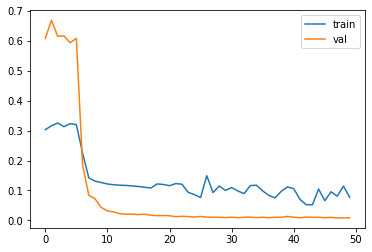

In [ ]:
# define model_2
model_2 = Sequential()
model_2.add(Bidirectional(LSTM(100, activation='relu', return_sequences = True), input_shape=(train_x.shape[1], train_x.shape[2])))
model_2.add(LSTM(50, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2])))
model_2.add(Dense(50))
model_2.add(Dense(1))
model_2.compile(loss='mse', optimizer='adam')


# fit model
history = model_2.fit(train_x, train_y, epochs=50, batch_size=72, validation_data=(test_x, test_y), verbose=1, shuffle=False)


# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Se obtiene los valores de error de validación y de entrenamiento observando que se aproximan al entrenar el modelo.
El error de validación baja por debajo del error de entrenamiento es por la cantidad de datos que se tiene hay menos datos para el conjunto de validación que el conjunto de entrenamiento.

# Inferencia

In [ ]:
!pip install chart_studio

     |████████████████████████████████| 71kB 4.1MB/s 


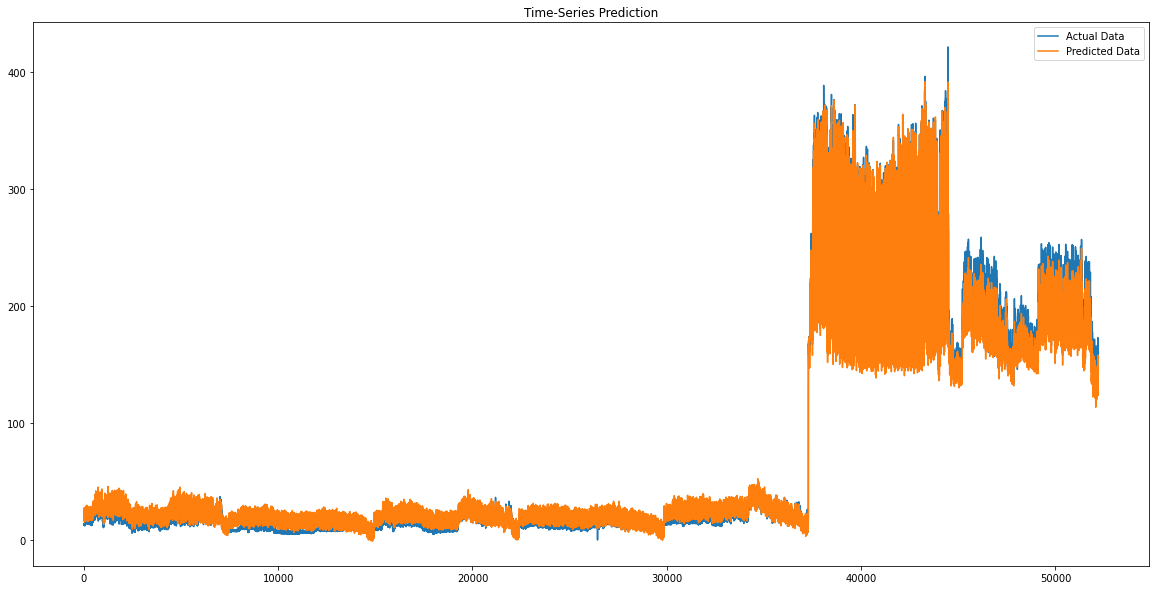

Test RMSE: 12.356


In [ ]:
from matplotlib import pyplot as plt

y_predict = model_2.predict(test_x)#forward pass y_predict = model.predict(test_X)
y_actual = test_y #actual data

y_predict = scaler_y.inverse_transform(y_predict) #reverse transformation
y_actual = scaler_y.inverse_transform(y_actual)

plt.figure(figsize=(20,10)) #plotting
#plt.axvline(x=train_hours, c='r', linestyle='--') #size of the training set

plt.plot(y_actual, label='Actual Data') #actual plot
plt.plot(y_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

rmse = np.sqrt(mean_squared_error(y_actual, y_predict ))
print('Test RMSE: %.3f' % rmse)

Se obtuvo la anterior grafica comparando los datos actuales (azul) y los datos predichos (naranja) graficando tiempo (horas) vs consumo eléctrico (en kBTU). La grafica corresponde al consumo eléctrico de 7 edificios por lo que tenemos 7 'bloques' diferentes en donde un punto en esta grafica representa el consumo eléctrico en una hora de un edificio por lo que tenemos 365*24 puntos para cada edificio. Vemos que en algunos casos la predicción no es buena pero para otros casos fue adecuada. La 'subida' en la grafica representa el consumo eléctrico de un edificio que consume más energía que los otros 5 edificios de la izquierda llegando hasta casi los 400 kBTU por lo que aprendió a estimar las fluctuaciones debidas al tamaño del edificio.

Se hace una grafica de interacción para observar con más detalle los datos.

In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
# Offline mode
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected='true')

In [ ]:
y_predict = y_predict.flatten()
y_actual = y_actual.flatten()

In [ ]:
Predicted = go.Scatter(x=np.arange(len(y_predict)), y=y_predict, opacity = 1, name = 'Valor Estimado', line=dict(color='royalblue'), yaxis='y')
Actual = go.Scatter(x=np.arange(len(y_actual)), y=y_actual, opacity = 0.7, name = 'Valor Actual', line=dict(color='lightblue'), yaxis='y')

layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Predicted, Actual], layout=layout)
fig.show(renderer="colab")

Vemos que como el modelo anterior se puede mejorar el modelo, para este caso, se propone aumentar el numero de épocas para ajustar aún mejor la predicción a los datos actuales.